#Part A

In [52]:
import pandas as pd
from pandas import Series
import numpy as np
%pylab inline
import nltk
from nltk import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import matplotlib.pyplot as plt
import re
import math
from collections import Counter
from operator import itemgetter


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [4]:
salary_data = pd.read_csv("Train_rev1.csv")

Top 5 Parts of Speech (Question A1)
Axes(0.125,0.125;0.775x0.775)


,Description,Count
NN,"noun, common, singular or mass",1036425
IN,"preposition or conjunction, subordinating",395710
NNS,"noun, common, plural",294683
DT,determiner,283371
JJ,"adjective or numeral, ordinal",241012


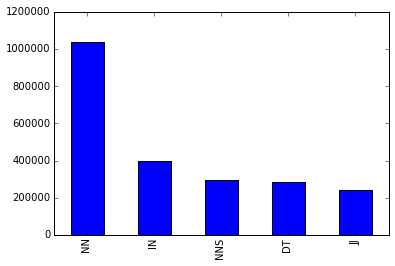

In [48]:
#Import data and find unique tokens
rawdata = salary_data
desc = rawdata['FullDescription']

working_data = rawdata[0:15000]
wordslist = []


for index, row in enumerate(working_data['FullDescription']):
    string = row.decode('utf-8')
    temp = word_tokenize(string)
    for i in temp:
        wordslist.append(i)

wordset = list(set(wordslist))

#Lowercase the document
stemmed_tokens = [t.lower() for t in wordset if t.isalpha()]
lower_wordlist = [t.lower() for t in wordslist if t.isalpha()]
wordset = list(set(stemmed_tokens))

counts = Counter(lower_wordlist) #Returns a dict of words and their frequency in the corpus

#Parts of Speach
pos_tokens = nltk.pos_tag(wordset)

compiled_pos_freq = [(word, tag, counts[word]) for (word, tag) in pos_tokens]

#Create a frequency distribution
#list_of_tags = []
#for (word, tag, count) in compiled_pos_freq:
#    for i in range(0,count):
#        list_of_tags.append() #Compiled into the list comprension
tokens_fd = nltk.FreqDist(tag for (word, tag, count) in compiled_pos_freq for i in range(0,count)) #Cross check later to see if amount is correct

#tokens_fd1 = nltk.FreqDist(tag for (word, tag) in pos_tokens)

#Answers for A1
sorted_pos = sorted(tokens_fd.items(), key=itemgetter(1), reverse = True)
print 'Top 5 Parts of Speech (Question A1)'

xvar = [x for (x, y) in sorted_pos]
series_plot = pd.Series([y for (x, y) in sorted_pos], index=xvar)
print(series_plot[0:5].plot(kind='bar'))




from nltk.data import load
labels=load('help/tagsets/upenn_tagset.pickle')
dictionary=pd.Series({key: labels[key][0] for key in labels.keys()})
pd.concat([dictionary,series_plot[0:5]],axis=1,join="inner").rename(columns={0:'Description',1:'Count'})

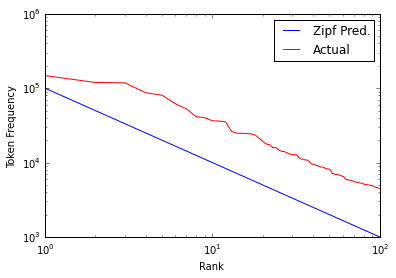

Does this corpus support Zipf's Law? (Question A2)
Zipf's law does hold true here because there is an inverse relationship between rank and token frequency, however comparing our predictured Zipfs value against our actual value showed some seperation likely due to stop words


In [50]:
#A2 requires calculation of a series of values for zipfs law, creating a two varaible dataframe
dict_wordcounts = Counter(lower_wordlist)
list_wordcounts = dict_wordcounts.most_common(100)

index = []
for i in range(1,len(list_wordcounts)+1):
    index.append(i)
top100 = pd.Series([b for (a, b) in list_wordcounts]) #Get the frequencies for the top 100 frequencies
top100words = pd.Series([a for (a, b) in list_wordcounts])  #The top freq words
#top100 = pd.Series([math.log(b) for (a, b) in sorted][0:101]) #Get the frequencies for the top 100 frequencies

zipf = []
for i,value in enumerate(top100):
    zipf.append((100000.0/(i+1))) ##Scaling the Zipf's calculation due to difference in magnitude Unsure how to calculate Zipfs Law Prediction
index = pd.Series(index)
zipf = pd.Series(zipf)

zipf = pd.concat([index,zipf, top100], axis=1)

plt.plot(zipf[[0]], zipf[[1]], 'b-', label = 'Zipf Pred.')
plt.plot(zipf[[0]], zipf[[2]], 'r-', label = 'Actual')
plt.yscale('log')
plt.xlabel('Rank')
plt.ylabel('Token Frequency')
plt.xscale('log')
plt.legend()
plt.show()

print 'Does this corpus support Zipf\'s Law? (Question A2)'
print 'Zipf\'s law does hold true here because there is an inverse relationship between rank and token frequency, however comparing our predictured Zipfs value against our actual value showed some seperation likely due to stop words'

Top 10 Words without stop words and lemmatized, what are their frequencies? (Question A3)
experience    24909
work          18196
role          16962
team          16271
client        16129
care          14231
working       13996
service       13729
skill         13173
within        12795
dtype: int64
Axes(0.125,0.125;0.775x0.775)


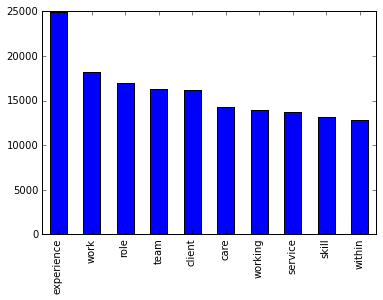

In [53]:
#For Part A3 we must remove stop words and lemmatize the corpus to find the most common parts of speech
#Remove Stop Words

#Lemmatize and remove stop words
nostop = [word for word in lower_wordlist if word not in stopwords.words('english')]
lmtzr = WordNetLemmatizer()
nostoplmtzed = [lmtzr.lemmatize(word) for word in nostop]
print('Top 10 Words without stop words and lemmatized, what are their frequencies? (Question A3)')
print(pd.Series(nostoplmtzed).value_counts()[:10])
print(pd.Series(nostoplmtzed).value_counts()[:10].plot(kind='bar'))

#Part B

In [54]:
import random
np.random.seed(1234567)
sample = salary_data.sample(15000, replace=False).copy()
salaries = sample['SalaryNormalized']
threshold = np.percentile(salaries, 75)

In [55]:
sample['High'] = 0.0
high_mask = sample['SalaryNormalized'] >= threshold
sample.ix[high_mask,'High'] = 1

In [56]:
train = sample.sample(0.6*len(sample), replace=False).copy()
test = sample[~sample.index.isin(train.index.values)]

In [57]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn import metrics
from operator import itemgetter
#from sklearn.metrics import classification_report


In [58]:
train_x = train['FullDescription']
train_y = train['High']

test_x = test['FullDescription']
test_y = test['High']

In [59]:
#wrapper
vectorizer = TfidfVectorizer(min_df=0, smooth_idf=True, strip_accents='unicode', norm='l2')

In [60]:
def tester (v):
    X_transform=v.fit_transform(train_x)
    X_test=v.transform(test_x)
    
    nb_classifier = MultinomialNB().fit(X_transform, train_y)
    y_nb_predicted = nb_classifier.predict(X_test)
    
    predict_y=Series(y_nb_predicted).reset_index()[0]
    df=pd.DataFrame()
    df['Predicted']=predict_y
    df['Test']=test_y.reset_index()['High']
    
    print "Percent Correct\n",round((df['Predicted']==df['Test']).mean()*100,3)
    print "\nConfusion Matrix\n",pd.crosstab(index=df['Test'],columns=df['Predicted'])
    print "\nProportion Table\n", pd.crosstab(index=df['Test'],columns=df['Predicted']).apply(lambda r: r/r.sum(), axis=1)

In [61]:
tester(vectorizer)

Percent Correct
75.017

Confusion Matrix
Predicted     0   1
Test               
0          4482   1
1          1498  19

Proportion Table
Predicted         0         1
Test                         
0          0.999777  0.000223
1          0.987475  0.012525


##Part B 1 with equal sized classes

In [62]:
salary_data['High']=0.0
high_mask = salary_data['SalaryNormalized'] >= threshold
salary_data.ix[high_mask,'High'] = 1.0

In [63]:
highs=salary_data[salary_data['High']==1]
lows=salary_data[salary_data['High']!=1]

In [64]:
samples_high=highs.sample(7500, replace=False).copy()
samples_lows=lows.sample(7500, replace=False).copy()
samples=samples_high.append(samples_lows, ignore_index=False, verify_integrity=True)

In [65]:
train = samples.sample(0.6*len(samples), replace=False).copy()
test = samples[~samples.index.isin(train.index.values)]

In [66]:
train_x = train['FullDescription']
train_y = train['High']
test_x = test['FullDescription']
test_y = test['High']

In [67]:
tester(vectorizer)

Percent Correct
80.15

Confusion Matrix
Predicted     0     1
Test                 
0          2240   741
1           450  2569

Proportion Table
Predicted         0         1
Test                         
0          0.751426  0.248574
1          0.149056  0.850944


#B2

In [68]:
#following scikit documentation to lemmatize
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [69]:
lemma_vectorizer = TfidfVectorizer(min_df=0, smooth_idf=True, strip_accents='unicode', norm='l2', tokenizer=LemmaTokenizer())

In [70]:
tester(lemma_vectorizer)

Percent Correct
79.733

Confusion Matrix
Predicted     0     1
Test                 
0          2233   748
1           468  2551

Proportion Table
Predicted         0         1
Test                         
0          0.749077  0.250923
1          0.155018  0.844982


_Lemmatization is just slightly worse._

#B3

In [71]:
stop_vectorizer = \
TfidfVectorizer(min_df=0, smooth_idf=True, strip_accents='unicode',\
                norm='l2', stop_words="english")

In [72]:
tester(stop_vectorizer)

Percent Correct
80.067

Confusion Matrix
Predicted     0     1
Test                 
0          2212   769
1           427  2592

Proportion Table
Predicted         0         1
Test                         
0          0.742033  0.257967
1          0.141438  0.858562


##Top Ten Words (using Coef)

In [73]:
#This second set is used for part B3-2
salary_data['Low']=0.0
low_mask = salary_data['SalaryNormalized'] <= threshold
salary_data.ix[low_mask,'Low'] = 1.0

highs=salary_data[salary_data['High']==1]
lows=salary_data[salary_data['High']!=1]


train_xB3 = train['FullDescription']
train_yB3 = train['Low']
test_xB3 = test['FullDescription']
test_yB3 = test['Low']

X_transformB3 =stop_vectorizer.fit_transform(train_xB3)
X_testB3 =stop_vectorizer.transform(test_xB3)

nb_classifierB3 = MultinomialNB().fit(X_transformB3, train_yB3)
y_nb_predictedB3 = nb_classifierB3.predict(X_testB3)

N = 10
vocabulary = np.array([t for t, i in sorted(stop_vectorizer.vocabulary_.iteritems(), key=itemgetter(1))])
print('Top Ten Words indicative of a low salary')
topNlows = np.argsort(nb_classifierB3.coef_[0])[-10:]
print(" ".join(vocabulary[topNlows]))



#High Salaries
train_xB3 = train['FullDescription']
train_yB3 = train['High']
test_xB3 = test['FullDescription']
test_yB3 = test['High']

X_transformB3 =stop_vectorizer.fit_transform(train_xB3)
X_testB3 =stop_vectorizer.transform(test_xB3)

nb_classifierB3 = MultinomialNB().fit(X_transformB3, train_yB3)
y_nb_predictedB3 = nb_classifierB3.predict(X_testB3)

N = 10
vocabulary = np.array([t for t, i in sorted(stop_vectorizer.vocabulary_.iteritems(), key=itemgetter(1))])
print('\nTop Ten words indicative of a high salary')
bottomNlows = np.argsort(nb_classifierB3.coef_[0])[-10:]
print(" ".join(vocabulary[bottomNlows]))


Top Ten Words indicative of a low salary
care service business skills working team role work experience sales

Top Ten words indicative of a high salary
design client development team manager role project management business experience


##Top Ten Words (Log Probability Ratio)

In [74]:
#Creating a vectorizer and model for part B3-2
stop_vectorizer = \
TfidfVectorizer(min_df=0, smooth_idf=True, strip_accents='unicode',\
                norm='l2', stop_words="english")
stop_train_x = stop_vectorizer.fit_transform(train_x)
stop_test_x = stop_vectorizer.transform(test_x)
stop_nb_classifier = MultinomialNB().fit(stop_train_x, train_y)

In [75]:
import math
class0log = stop_nb_classifier.feature_log_prob_[0]
class1log = stop_nb_classifier.feature_log_prob_[1]
class1log_exp = []
for i in class1log:
    class1log_exp.append(math.exp(i))
class0log_exp = []
for j in class0log:
    class0log_exp.append(math.exp(j))
ratio = []
for index, var in enumerate(class1log_exp):
    ratio.append(class0log_exp[index]/var)

bottomN1 = np.argsort(ratio)[:10]
print('Words most indicative of a higher salary:')
print(" ".join(vocabulary[bottomN1]))
topN1 = np.argsort(ratio)[-10:]
print('\nWords most indicative of a lower salary: ')
print(" ".join(vocabulary[topN1]))

Words most indicative of a higher salary:
architect derivatives allegis treasury transformation subsea architecture lawyer hibernate ee

Words most indicative of a lower salary: 
cnc teachers chef adecco assistant asbestos cleaning sous hgv partie


#B4

In [76]:
class posBigram(object):
    def __init__(self):
        pass
    def __call__(self,doc):
      return nltk.Text(nltk.bigrams([i[1] for i in nltk.pos_tag(nltk.word_tokenize(doc))]))

In [77]:
pos_bigram_vectorizer = TfidfVectorizer(min_df=0, smooth_idf=True, strip_accents='unicode', norm='l2', tokenizer=posBigram())

In [78]:
pos_bigram_train_x = pos_bigram_vectorizer.fit_transform(train_x) #defines dictionary
pos_bigram_nb_classifier = MultinomialNB().fit(pos_bigram_train_x, train_y)

In [79]:
pos_bigram_test_x = pos_bigram_vectorizer.transform(test_x)
pos_bigram_y_nb_predicted = pos_bigram_nb_classifier.predict(pos_bigram_test_x)

In [80]:
pos_bigram_predict_y = Series(pos_bigram_y_nb_predicted).reset_index()
pos_bigram_predict_y = pos_bigram_predict_y[0]
pos_bigram_df = pd.DataFrame()
pos_bigram_df['Predicted'] = pos_bigram_predict_y
pos_bigram_df['Actual'] = test_y.reset_index()['High']
pd.crosstab(index=pos_bigram_df['Actual'], columns=pos_bigram_df['Predicted'])

Predicted,0.0,1.0
Actual,,
0,1782,1199
1,987,2032


In [81]:
(pos_bigram_df['Predicted'] == pos_bigram_df['Actual']).mean()

0.63566666666666671